# Accuracy of global spatial analysis as dependent on image size vs wavelength

## Preparation
Import of required modules and packages.

In [1]:
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib.patches import Rectangle
from IPython.display import clear_output

from min_analysis_tools import correlation_tools

# Reload modules automatically before executing code
%reload_ext autoreload
%autoreload 2

plt.rc("font", size=10)  # controls default text size
plt.rcParams.update({"font.family": "arial"})

In [ ]:
# save set to True -> selected images saved to save_output
save = False
save_dpi = 150
cm = 1 / 2.54  # centimeters in inches (for matplotlib figure size)

## Selection

Select input path: (select square-shaped image)

In [2]:
stack_path = Path().cwd() / "example_data" / "accuracy_test.tif"

Load image: (do not change)

In [3]:
Min_st = io.imread(stack_path)
nt, ny, nx = np.shape(Min_st)

Select number of frames to analyse:

In [4]:
frames_to_analyse = 10  # analyse first .. frames (global/spatial and local analysis)

Select image dimensions in pixels. Images will be cropped to these sizes and analysed. For the sake of clarity, we show the crops here aligned on their top left corner. For the actual analysis, The position of cropped areas is varied at random to avoid selection bias.

In [5]:
dimensions = list(
    range(128, nx, 32)
)  # range: provide start, stop (= horizontal image size) and step
dimensions.reverse()  # reverse to go down from large to small

Display image and cropping sizes:

Current file size: 1425 pixels x 1425 pixels x 25 frames


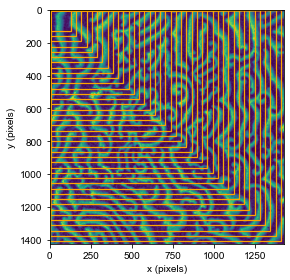

In [6]:
print(f"Current file size: {nx} pixels x {ny} pixels x {nt} frames")
fig, ax = plt.subplots()
ax.imshow(Min_st[0, :, :])
ax.set_xlabel("x (pixels)")
ax.set_ylabel("y (pixels)")

for dim in dimensions:
    ax.add_patch(
        Rectangle(
            (0, 0), dim, dim, edgecolor="orange", facecolor="None", fill=True, lw=1.25
        )
    )
fig.tight_layout()

if save:
    fig.set_size_inches(8 * cm, 8 * cm)
    fig.tight_layout()
    fig.savefig(
        r"save_output\global_spatial_cropping_sizes.png", dpi=save_dpi, transparent=True
    )
plt.show()

Specify how many randomized cropping regions to use:

In [7]:
repeats = 10

## Spatial autocorrelation
Spatial autocorrelation analysis is performed on a set number of images per movie. For each autocorrelation output image, a radial profile is recorded starting from the main central correlation peak. The resulting spatial radial correlation curves are subjected to maxima analysis. The first maximum after radius $R=0$ indicates the most predominant distance between wave edges, irrespective of propagation direction. This distance is identified as the pattern's global wavelength.

In [8]:
def spatial_autocorrelation(Min_st, frames_to_analyse, demo=False):
    nt, ny, nx = np.shape(Min_st)
    title = f"size: {nx} pixels x {ny} pixels"

    # calculate spatial autocorrelation maps for all analysed frames
    (crmx_storage) = correlation_tools.get_spatial_correlation_matrixes(
        Min_st, frames_to_analyse, demo=False
    )

    if demo:
        # calculate radially averaged profile traces and analyze them with respect to first min and max
        (
            min_pos,
            min_val,
            max_pos,
            max_val,
            fig,
            ax,
        ) = correlation_tools.analyze_radial_profiles(crmx_storage, demo=True)
        ax.set_title(title, fontsize=10)
    else:
        # calculate radially averaged profile traces and analyze them with respect to first min and max
        (
            min_pos,
            min_val,
            max_pos,
            max_val,
        ) = correlation_tools.analyze_radial_profiles(crmx_storage, demo=False)

    wavelength = np.mean(max_pos)
    wavelength_std = np.std(max_pos)
    print(
        f"Position of first valley: ({np.mean(min_pos):.02f} ± {np.std(min_pos):.02f}) pixels"
    )
    print(f"Wavelength: ({wavelength:.02f} ± {wavelength_std:.02f}) pixels")
    print("")

    if demo:
        return wavelength, wavelength_std, fig, ax
    else:
        return wavelength, wavelength_std

### Analyse full image stack

First, analyse the entire image. The wavelength obtained from the full image will be considered the most accurate, and hence be referred to as reference wavelength $\lambda_{ref}$.

Analysing 10 frames
Position of first valley: (42.10 ± 0.70) pixels
Wavelength: (78.70 ± 1.55) pixels



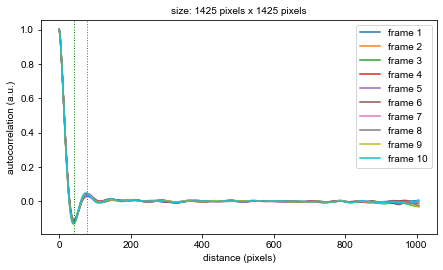

In [9]:
ref_wavelength, ref_wavelength_std, fig, ax = spatial_autocorrelation(
    Min_st, frames_to_analyse, demo=True
)

if save:
    ax.tick_params(direction="in")
    fig.set_size_inches(10 * cm, 8 * cm)
    fig.tight_layout()
    fig.savefig(
        "save_output/global_spatial_full_analysis.png", dpi=save_dpi, transparent=True
    )
plt.show()

### Analyse cropped image stacks
Next, crop the image stack further and perform the analysis again for every selected dimension.

In [10]:
wavelengths_collect = []
wavelengths_std_collect = []

clear_output(wait=False)

for dim in dimensions:
    plt.close("all")
    fig0, ax0 = plt.subplots()
    ax0.imshow(Min_st[0, :, :])
    ax0.set_xlabel("x (pixels)")
    ax0.set_ylabel("y (pixels)")

    start_random_x = []
    start_random_y = []

    for n in range(repeats):
        x_0 = int((np.random.uniform(0, nx - dim, 1)))
        start_random_x.append(x_0)
        y_0 = int((np.random.uniform(0, ny - dim, 1)))
        start_random_y.append(y_0)
        ax0.add_patch(
            Rectangle(
                (y_0, x_0),
                dim,
                dim,
                edgecolor="orange",
                facecolor="None",
                fill=True,
                lw=1.5,
            )
        )

    if save:
        fig0.set_size_inches(8 * cm, 8 * cm)
        fig0.tight_layout()
        fig0.savefig(
            f"save_output/global_spatial_{dim}_cropping.png",
            dpi=save_dpi,
            transparent=True,
        )
    plt.show()

    for n in range(repeats):
        x_0 = start_random_x[n]
        y_0 = start_random_y[n]
        Min_st_new = Min_st[:, y_0 : y_0 + dim, x_0 : x_0 + dim]
        print(f"dimension = {dim}, x_0 = {x_0=}, y_0 = {y_0}")

        if n == 0:
            wavelength, wavelength_std, fig, ax = spatial_autocorrelation(
                Min_st_new, frames_to_analyse, demo=True
            )
            plt.show()
        else:
            wavelength, wavelength_std = spatial_autocorrelation(
                Min_st_new, frames_to_analyse
            )

        wavelengths_collect.append(wavelength)
        wavelengths_std_collect.append(wavelength_std)

    clear_output(wait=False)
    plt.close("all")

## Results
In the following, we consider the wavelength obtained for the full image as reference wavelength $\lambda_{ref}$ and compare the results obtained for different image sizes (in units of $\lambda_{ref}$).

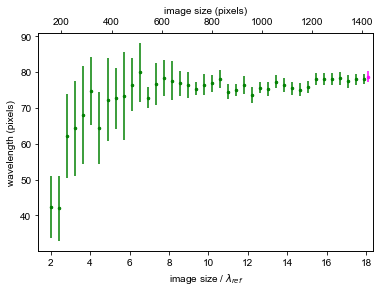

In [11]:
fig, ax = plt.subplots()
ax_twin = ax.twiny()

ax.set_xlabel("image size / $λ_{ref}$")
ax.set_ylabel("wavelength (pixels)")
ax_twin.set_xlabel("image size (pixels)")

min_ax = min(dimensions) / ref_wavelength - 0.25
max_ax = nx / ref_wavelength + 0.25
ax.set_xlim((min_ax, max_ax))
ax_twin.set_xlim((min_ax * ref_wavelength, max_ax * ref_wavelength))

for n, dim in enumerate(dimensions):

    wavelengths = wavelengths_collect[n * repeats : n * repeats + repeats]
    wavelength_stds = wavelengths_std_collect[n * repeats : n * repeats + repeats]

    wavelengths = np.array(wavelengths)
    wavelength = np.mean(wavelengths)

    wavelength_stds = np.array(wavelength_stds)
    wavelength_std = np.sqrt(np.sum(wavelength_stds * wavelength_stds) / repeats)

    ax.errorbar(
        (dim / ref_wavelength),
        wavelength,
        yerr=wavelength_std,
        marker=".",
        markersize=5,
        color="green",
    )

ax.errorbar(
    (nx / ref_wavelength),
    ref_wavelength,
    yerr=ref_wavelength_std,
    marker=".",
    markersize=5,
    color="magenta",
)

if save:
    fig.set_size_inches(10 * cm, 8 * cm)
    fig.tight_layout()
    fig.savefig(
        f"save_output/global_spatial_cropping_results.png",
        dpi=save_dpi,
        transparent=True,
    )
plt.show()

Above, the reference wavelength (with standard deviation) is given in red, the results for cropped images (mean and standard deviation) are given in blue. The lower limit of the size : wavelength ratio is given by the size at which results significantly differ from the reference wavelength.<br>
Note that as long as the first peak and valley are still identifyable by eye in the radial autocorrelation curves above, choosing a better peak fitting routine can improve results if required.